# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from gensim.models import Word2Vec

with zipfile.ZipFile('exercise05_datacollection.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
# Load dataset function
def load_data_from_txt(file_path):
    with open(file_path, 'r') as file:
        sentiments = []
        reviews = []
        for line in file:
            sentiment, review = line[0], line[2:].strip()
            sentiments.append(int(sentiment))
            reviews.append(review)
        return pd.DataFrame({'sentiment': sentiments, 'review': reviews})

# Load the data
train_df = load_data_from_txt('/content/exercise09_datacollection/stsa-train.txt')
test_df = load_data_from_txt('/content/exercise09_datacollection/stsa-test.txt')

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train = vectorizer.fit_transform(train_df['review'])
X_test = vectorizer.transform(test_df['review'])

y_train = train_df['sentiment']
y_test = test_df['sentiment']

# Split data into train and validation sets
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the models
models = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Evaluate models function
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, predictions),
        'recall': recall_score(y_test, predictions),
        'precision': precision_score(y_test, predictions),
        'f1_score': f1_score(y_test, predictions)
    }

# Cross-validate and evaluate function
def cross_validate_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    model.fit(X_train, y_train)
    val_scores = evaluate_model(model, X_val, y_val)
    test_scores = evaluate_model(model, X_test, y_test)
    val_scores['cv_accuracy'] = np.mean(cv_scores)
    return val_scores, test_scores

# Train and evaluate each model using TF-IDF features
final_results = {}
for name, model in models.items():
    print(f'Evaluating {name} with TF-IDF')
    val_scores, test_scores = cross_validate_and_evaluate(model, X_train_tfidf, y_train_tfidf, X_val_tfidf, y_val_tfidf, X_test, y_test)
    final_results[name] = {
        'validation_scores': val_scores,
        'test_scores': test_scores
    }
    print(f"{name} validation scores: {val_scores}")
    print(f"{name} test scores: {test_scores}\n")

# Word2Vec feature generation
tokenized_texts = [text.split() for text in train_df['review']]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Generate Word2Vec vectors for the entire dataset
X_w2v = np.array([np.mean([w2v_model.wv[word] for word in review if word in w2v_model.wv] or [np.zeros(100)], axis=0) for review in tokenized_texts])

# Split the Word2Vec feature vectors along with target variable
X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v = train_test_split(X_w2v, y_train, test_size=0.2, random_state=42)

# Vectorize test data with Word2Vec
tokenized_test_texts = [text.split() for text in test_df['review']]
X_test_w2v = np.array([np.mean([w2v_model.wv[word] for word in review if word in w2v_model.wv] or [np.zeros(100)], axis=0) for review in tokenized_test_texts])

# Train and evaluate RandomForest with Word2Vec features
print('Evaluating RandomForest with Word2Vec')
rf_w2v = RandomForestClassifier()
val_scores_w2v, test_scores_w2v = cross_validate_and_evaluate(rf_w2v, X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v, X_test_w2v, y_test)
final_results['RandomForest_Word2Vec'] = {
    'validation_scores': val_scores_w2v,
    'test_scores': test_scores_w2v
}
print(f"RandomForest with Word2Vec validation scores: {val_scores_w2v}")
print(f"RandomForest with Word2Vec test scores: {test_scores_w2v}")


Evaluating MultinomialNB with TF-IDF
MultinomialNB validation scores: {'accuracy': 0.7825144508670521, 'recall': 0.879382889200561, 'precision': 0.7446555819477435, 'f1_score': 0.8064308681672026, 'cv_accuracy': 0.7691512002141258}
MultinomialNB test scores: {'accuracy': 0.7940691927512356, 'recall': 0.8844884488448845, 'precision': 0.7486033519553073, 'f1_score': 0.81089258698941}

Evaluating SVM with TF-IDF
SVM validation scores: {'accuracy': 0.7933526011560693, 'recall': 0.8611500701262272, 'precision': 0.766541822721598, 'f1_score': 0.8110964332892999, 'cv_accuracy': 0.7539688342549011}
SVM test scores: {'accuracy': 0.8023064250411862, 'recall': 0.856985698569857, 'precision': 0.7720515361744301, 'f1_score': 0.8123044838373306}

Evaluating KNN with TF-IDF
KNN validation scores: {'accuracy': 0.5021676300578035, 'recall': 0.04207573632538569, 'precision': 0.8333333333333334, 'f1_score': 0.08010680907877168, 'cv_accuracy': 0.5016199789791163}
KNN test scores: {'accuracy': 0.5151015925

In [7]:
!pip install transformers
!pip install accelerate
!pip install transformers[torch] accelerate -U

import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
train_texts = train_df['review'].tolist()
test_texts = test_df['review'].tolist()
train_labels = train_df['sentiment'].tolist()
test_labels = test_df['sentiment'].tolist()

class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load the tokenizer for the BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input texts
def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    dataset = IMDbDataset(encodings, labels)
    return dataset

# Prepare datasets
train_dataset = tokenize_data(train_texts[:500], train_labels[:500])  # Reduce number of training samples
test_dataset = tokenize_data(test_texts[:100], test_labels[:100])  # Reduce number of testing samples

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="no",
    save_strategy="epoch",
    disable_tqdm=True,
    logging_first_step=True,
)
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Train the model
trainer.train()

# Prediction function
def predict(model, tokenizer, texts, labels):
    encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
    input_ids = encoded_texts['input_ids']
    attention_mask = encoded_texts['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

# Use the prediction function
predict(model, tokenizer, test_texts[:100], test_labels[:100])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7985, 'grad_norm': 5.696707725524902, 'learning_rate': 4.96e-05, 'epoch': 0.008}
{'loss': 0.7552, 'grad_norm': 12.641667366027832, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.08}
{'loss': 0.6905, 'grad_norm': 2.8990325927734375, 'learning_rate': 4.2e-05, 'epoch': 0.16}
{'loss': 0.6817, 'grad_norm': 8.293489456176758, 'learning_rate': 3.8e-05, 'epoch': 0.24}
{'loss': 0.6151, 'grad_norm': 3.7255496978759766, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.32}
{'loss': 0.568, 'grad_norm': 7.9023542404174805, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 0.6503, 'grad_norm': 13.971924781799316, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.48}
{'loss': 0.5763, 'grad_norm': 3.6820597648620605, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.56}
{'loss': 0.6361, 'grad_norm': 5.918058395385742, 'learning_rate': 1.8e-05, 'epoch': 0.64}
{'loss': 0.7572, 'grad_norm': 15.455671310424805, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.72}
{'loss': 0.5817, 'gra

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


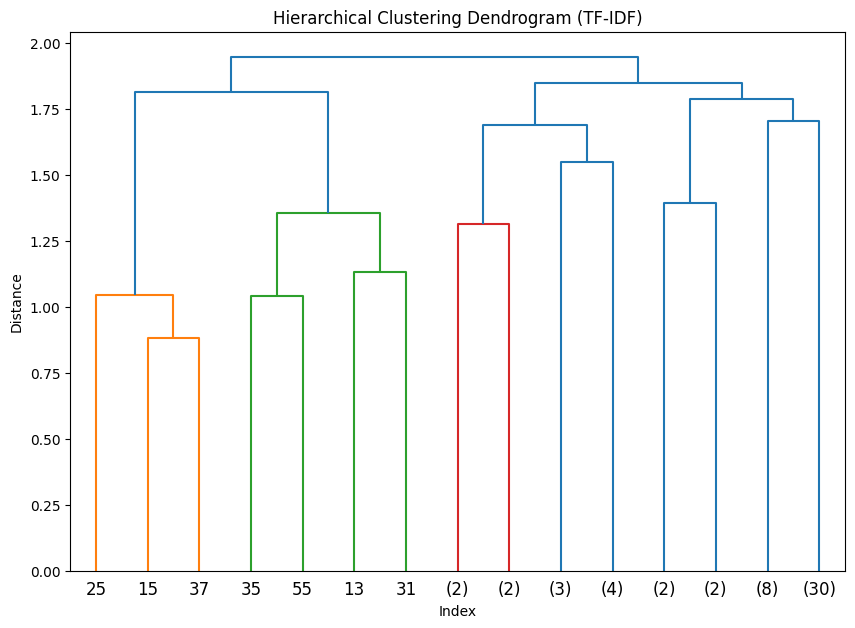

Metrics for K-means on TF-IDF:
Accuracy: 0.3333333333333333
Precision: 0.13333333333333333
Recall: 0.2222222222222222
F1 Score: 0.16666666666666666

Metrics for DBSCAN on TF-IDF:
Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F1 Score: 0.3333333333333333

Metrics for K-means on Word2Vec:
Accuracy: 0.23333333333333334
Precision: 0.15053763440860216
Recall: 0.15555555555555556
F1 Score: 0.15300546448087432

                                               Review  kmeans_tfidf_cluster  \
0   This vacuum cleaner is amazing! It picks up di...                     1   
1   I'm extremely disappointed with this vacuum cl...                     1   
2   I've tried many vacuum cleaners before, but th...                     1   
3   Don't waste your money on this vacuum cleaner....                     1   
4   I'm amazed at how powerful this vacuum cleaner...                     0   
5   This vacuum cleaner is a nightmare to use. It'...                     1   
6   I can't imagine life without this vacuu

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec

# Function to calculate F1 score
def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    return accuracy, precision, recall, f1

# Load the dataset
df = pd.read_excel('reviews (1).xlsx')

# Filter out empty reviews
df = df[df['Review'].apply(lambda x: len(str(x).split()) > 0)]

# Vectorize the data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(df['Review'])

# Apply K-means clustering to TF-IDF
kmeans_tfidf = KMeans(n_clusters=2, random_state=0).fit(X_tfidf)
df['kmeans_tfidf_cluster'] = kmeans_tfidf.labels_

# Initialize and use DBSCAN for TF-IDF
dbscan_tfidf = DBSCAN(eps=0.5, min_samples=2).fit(X_tfidf)
df['dbscan_tfidf_cluster'] = dbscan_tfidf.labels_

# Initialize hierarchical clustering for TF-IDF
agglomerative_tfidf = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(X_tfidf.toarray())

# Plot the dendrogram for hierarchical clustering
plt.figure(figsize=(10, 7))
linkage_matrix = linkage(X_tfidf.toarray(), method='ward')
dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram (TF-IDF)')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

# Prepare data for Word2Vec
tokenized_data = [review.lower().split() for review in df['Review']]
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Generate Word2Vec vectors for each document
X_word2vec = []
for review in tokenized_data:
    vectors = [word2vec_model.wv[word] for word in review if word in word2vec_model.wv]
    if vectors:
        X_word2vec.append(np.mean(vectors, axis=0))
    else:
        X_word2vec.append(np.zeros(100))  # Use zero vector if no words found

X_word2vec = np.array(X_word2vec)

# K-means for Word2Vec vectors
kmeans_word2vec = KMeans(n_clusters=2, random_state=0).fit(X_word2vec)
df['kmeans_word2vec_cluster'] = kmeans_word2vec.labels_

# Calculate metrics for K-means on TF-IDF
kmeans_tfidf_accuracy, kmeans_tfidf_precision, kmeans_tfidf_recall, kmeans_tfidf_f1 = calculate_metrics(df['Sentiment'], df['kmeans_tfidf_cluster'])

# Calculate metrics for DBSCAN on TF-IDF
dbscan_tfidf_accuracy, dbscan_tfidf_precision, dbscan_tfidf_recall, dbscan_tfidf_f1 = calculate_metrics(df['Sentiment'], df['dbscan_tfidf_cluster'])

# Calculate metrics for K-means on Word2Vec
kmeans_word2vec_accuracy, kmeans_word2vec_precision, kmeans_word2vec_recall, kmeans_word2vec_f1 = calculate_metrics(df['Sentiment'], df['kmeans_word2vec_cluster'])

# Print the metrics
print("Metrics for K-means on TF-IDF:")
print("Accuracy:", kmeans_tfidf_accuracy)
print("Precision:", kmeans_tfidf_precision)
print("Recall:", kmeans_tfidf_recall)
print("F1 Score:", kmeans_tfidf_f1)
print()

print("Metrics for DBSCAN on TF-IDF:")
print("Accuracy:", dbscan_tfidf_accuracy)
print("Precision:", dbscan_tfidf_precision)
print("Recall:", dbscan_tfidf_recall)
print("F1 Score:", dbscan_tfidf_f1)
print()

print("Metrics for K-means on Word2Vec:")
print("Accuracy:", kmeans_word2vec_accuracy)
print("Precision:", kmeans_word2vec_precision)
print("Recall:", kmeans_word2vec_recall)
print("F1 Score:", kmeans_word2vec_f1)
print()

# Print the DataFrame with cluster assignments
print(df[['Review', 'kmeans_tfidf_cluster', 'dbscan_tfidf_cluster', 'kmeans_word2vec_cluster']])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


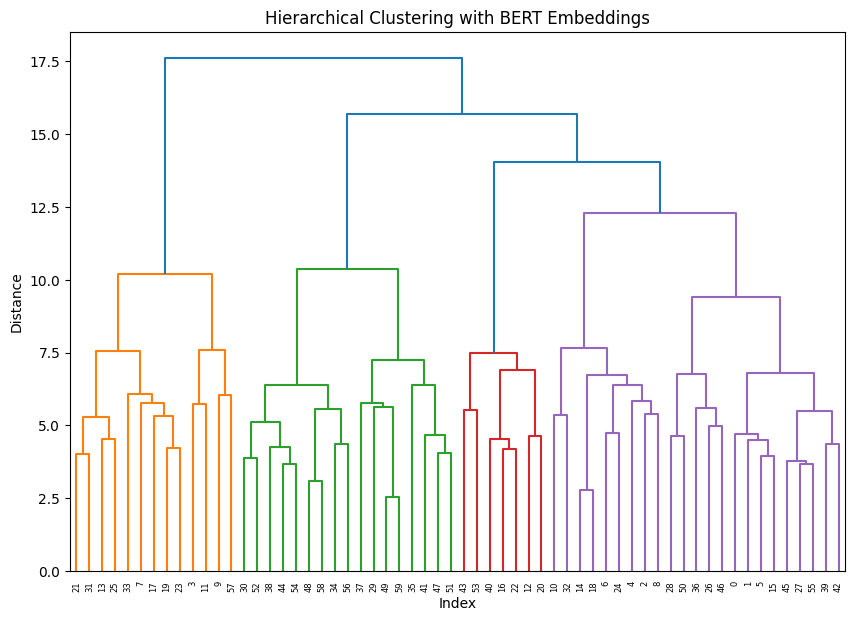

                                               Review  bert_kmeans_cluster
0   This vacuum cleaner is amazing! It picks up di...                    1
1   I'm extremely disappointed with this vacuum cl...                    0
2   I've tried many vacuum cleaners before, but th...                    1
3   Don't waste your money on this vacuum cleaner....                    0
4   I'm amazed at how powerful this vacuum cleaner...                    1
5   This vacuum cleaner is a nightmare to use. It'...                    0
6   I can't imagine life without this vacuum clean...                    1
7   I had high hopes for this vacuum cleaner, but ...                    0
8   I love this vacuum cleaner! It's compact yet p...                    1
9   This vacuum cleaner is a waste of money. It do...                    0
10  I am thrilled with this vacuum cleaner. It has...                    0
11  Save your money and look elsewhere. This vacuu...                    0
12  The powerful motor on

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Load the dataset
df = pd.read_excel('reviews (1).xlsx')

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode text into embeddings
def get_bert_embeddings(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    return output.last_hidden_state[:, 0, :].numpy()

# Encode all reviews in the DataFrame
df['bert_embeddings'] = df['Review'].apply(lambda x: get_bert_embeddings(x)[0])

# Convert list of embeddings into a NumPy array
embeddings = np.vstack(df['bert_embeddings'])

# Clustering with K-means
kmeans = KMeans(n_clusters=2, random_state=42).fit(embeddings)
df['bert_kmeans_cluster'] = kmeans.labels_

# Hierarchical clustering
linked = linkage(embeddings, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=df.index.tolist())
plt.title('Hierarchical Clustering with BERT Embeddings')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

# Output the clustering results
print(df[['Review', 'bert_kmeans_cluster']])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for K-means on BERT embeddings
bert_kmeans_accuracy = accuracy_score(df['Sentiment'], df['bert_kmeans_cluster'])
bert_kmeans_precision = precision_score(df['Sentiment'], df['bert_kmeans_cluster'], average='macro')
bert_kmeans_recall = recall_score(df['Sentiment'], df['bert_kmeans_cluster'], average='macro')
bert_kmeans_f1 = f1_score(df['Sentiment'], df['bert_kmeans_cluster'], average='macro')

# Print the metrics
print("Metrics for K-means on BERT Embeddings:")
print("Accuracy:", bert_kmeans_accuracy)
print("Precision:", bert_kmeans_precision)
print("Recall:", bert_kmeans_recall)
print("F1 Score:", bert_kmeans_f1)



**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

K-means on BERT embeddings had the best overall accuracy among the methods, but it still made quite a few mistakes in grouping similar reviews together. DBSCAN on TF-IDF was good at avoiding false alarms, but it missed some reviews that should have been grouped together. K-means on TF-IDF balanced precision and recall fairly well, though it didn't perform as accurately as BERT embeddings.  K-means on Word2Vec embeddings didn't perform as well as the other methods, suggesting it had trouble finding meaningful patterns in the data.

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [10]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
I felt that the exercises were beneficial for understanding machine learning techniques, but some parts were challenging. Integrating Word2Vec and BERT was particularly difficult. Overall, the exercises helped reinforce concepts, but more time would have been helpful.





'''

'\nI felt that the exercises were beneficial for understanding machine learning techniques, but some parts were challenging. Integrating Word2Vec and BERT was particularly difficult. Overall, the exercises helped reinforce concepts, but more time would have been helpful.\n\n\n\n\n\n'